In [1]:
from sae_lens import HookedSAETransformer
import torch
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import datasets
from collections import defaultdict
import time
import os
import json

In [2]:
def means_stds_ranks(layers, model_name, keys=None):

    means = defaultdict(list)
    stds = defaultdict(list)


    for layer in layers:
        filename =f'../../cruft/50_{model_name}_blocks.{layer}.hook_resid_pre_cos.json' 
        if os.path.exists(filename):
            with open(filename) as f:
                corrs = json.load(f)


            corrs = {key: corrs[key] for key in keys if key in corrs}

            for k, token_dict in corrs.items():
                if keys is None or k in keys:
                    s = torch.stack([torch.tensor(t) for t in token_dict]).mean(dim=0)
                    means[k].append(s.mean().item())
                    stds[k].append(s.std().item())


    print('means', means.keys())

    ranks = {k: [0] * len(layers) for k in means}
    for layer in range(len(layers)):
        layer_means = {k: means[k][layer] for k in means}
        sorted_keys = sorted(layer_means, key=layer_means.get, reverse=True)
        r = {key: rank for rank, key in enumerate(sorted_keys, 1)}

        for k in r:
            ranks[k][layer] = r[k]

    return means, ranks, stds

In [3]:
means, ranks, stds = means_stds_ranks(list(range(11)), 'gpt2-small', keys=['[t]', "[<bos>, t]",  "[t, t]", "[37233, t]", '[" ", t]', '[" ", " ", t]',])


means dict_keys(['[t]', '[<bos>, t]', '[t, t]', '[37233, t]', '[" ", t]', '[" ", " ", t]'])


In [11]:
cosines = {}
for k, v in means.items():
    print(round(v[10], 3), k)
    cosines[k] = v[10]

0.344 [t]
0.63 [<bos>, t]
0.651 [t, t]
0.632 [37233, t]
0.653 [" ", t]
0.647 [" ", " ", t]


In [20]:
mapping = {
    '[t]': 0.33162,
    "[<bos>, t]": 0.3179,
    "[t, t]": 0.32164,
    "[37233, t]": 0.3236,
    '[" ", t]': 0.31747,
    '[" ", " ", t]': 0.31257
}

Text(0.5, 0, 'Minimum Mean squared error achieved in Switch SAE Training')

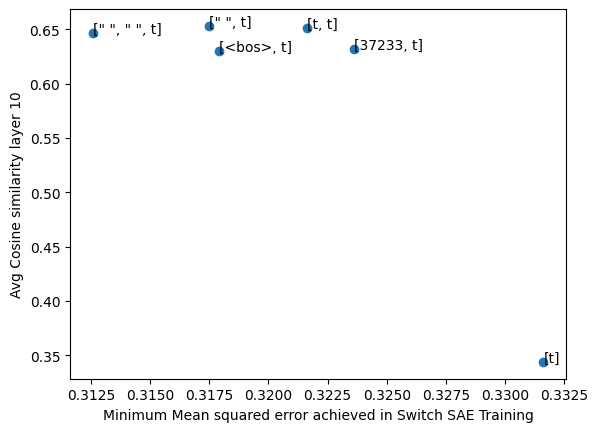

In [21]:
cos = []
mse = []

for k, v in cosines.items():
    cos.append(v)
    mse.append(mapping[k])

plt.scatter(mse, cos)
# add labels as k

for i, txt in enumerate(cosines.keys()):
    plt.annotate(txt, (mse[i], cos[i]))

plt.ylabel('Avg Cosine similarity layer 10')
plt.xlabel('Minimum Mean squared error achieved in Switch SAE Training')